# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 벡터 데이터베이스 튜토리얼

In [1]:
!pip install -q chromadb transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 3.1.0a0 requires httpx==0.13.3, but you have httpx 0.28.1 which is incompatible.
tensorflow 2.16.2 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.


## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [2]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

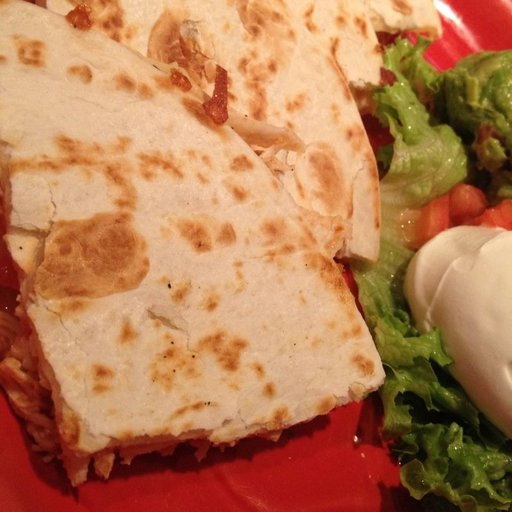

In [3]:
from PIL import Image

img = Image.open("test/Bread/0.jpg")

img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [5]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16')

print("Models loaded!")

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [7]:
img_tensor = feature_extractor(images=img, return_tensors="pt")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding

array([ 0.99646366,  0.99943525,  0.83149195,  0.99528825,  0.92598605,
       -0.9998844 ,  0.9980595 ,  0.9457553 ,  0.16707328, -0.39304236,
        0.9472609 , -0.9894161 ,  0.8491135 , -0.5768687 , -0.95230746,
        0.94023174, -0.93084127,  0.8539435 , -0.8947814 ,  0.70177954,
        0.94738203, -0.86438763,  0.8525952 ,  0.05573032, -0.07633615,
       -0.9966596 , -0.41028816,  0.72410977,  0.99969584, -0.9748357 ,
       -0.3015093 ,  0.68453115,  0.99921983,  0.71800184, -0.864198  ,
        0.91270804,  0.80010384,  0.94852686,  0.11178609,  0.4277275 ,
        0.8309034 , -0.9943677 ,  0.9800692 ,  0.86147165,  0.9898642 ,
       -0.99916106, -0.976109  ,  0.6198158 , -0.05829868,  0.99523807,
       -0.9907246 , -0.5702359 ,  0.36645994, -0.66711   ,  0.7753625 ,
        0.6362572 , -0.99922067,  0.6800832 ,  0.97796655, -0.14195211,
       -0.8437005 ,  0.8667772 ,  0.9995436 ,  0.9991688 ,  0.98136455,
       -0.13253273, -0.84618604, -0.15862906, -0.95477647,  0.98

In [8]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [9]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods")

## 모든 이미지 벡터화

In [10]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

In [12]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embedding_to_list = embedding.tolist()

    embeddings.append(embedding_to_list)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 110/110 [00:02<00:00, 39.32it/s]

Done!


## 임베딩을 데이터베이스에 저장

In [13]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## Test1

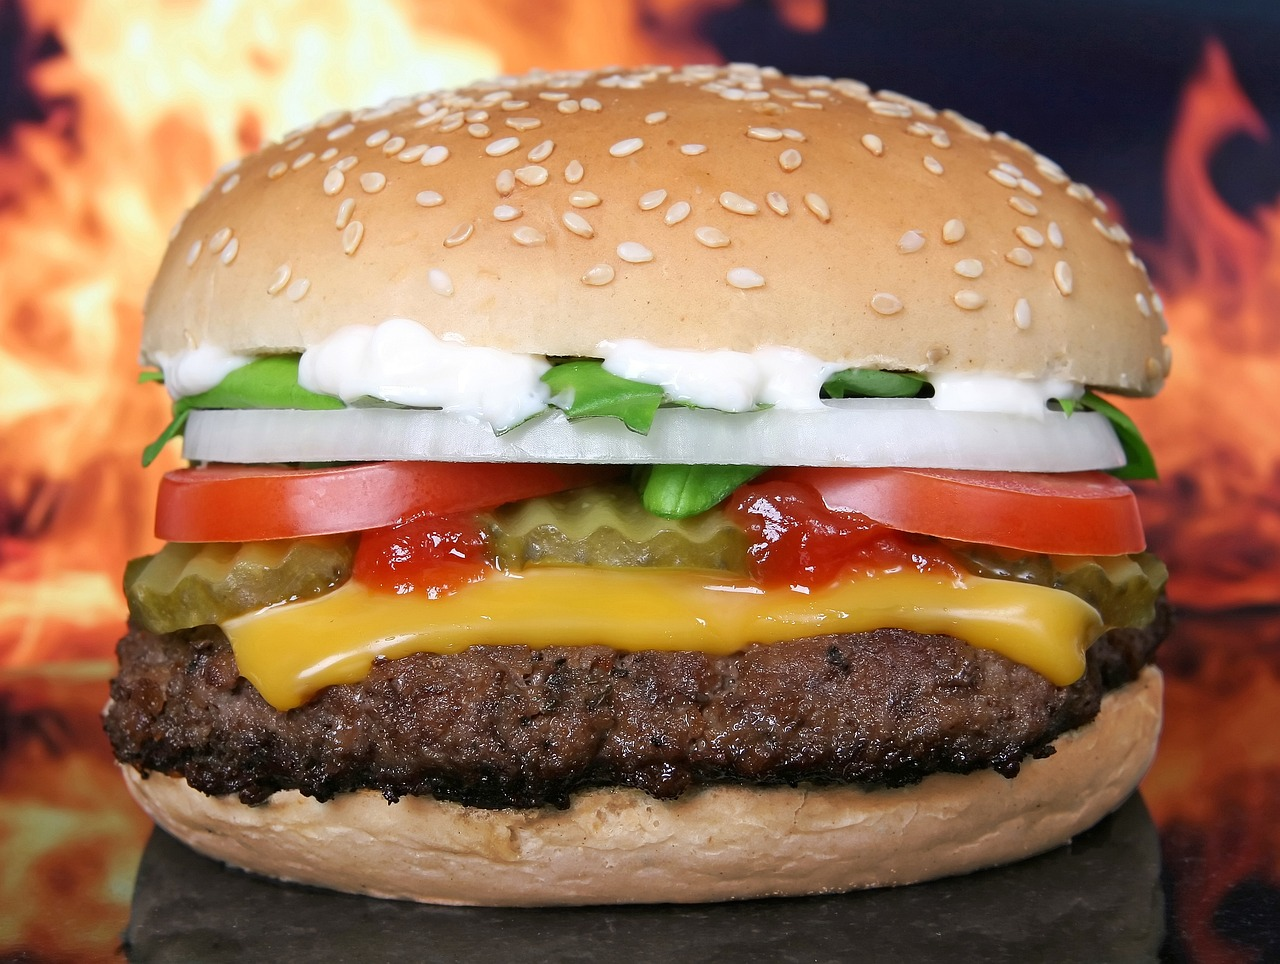

In [14]:
import requests

test_img = Image.open(requests.get("https://cdn.pixabay.com/photo/2016/03/05/19/02/hamburger-1238246_1280.jpg", stream=True).raw).convert("RGB")

test_img

In [16]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
test_embedding_list = test_embedding.tolist()

test_embedding.shape

(384,)

In [17]:
query_result = collection.query(
    query_embeddings=[test_embedding_list],
    n_results=3,
)

query_result

{'ids': [['8', '2', '6']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'uri': 'test/Bread/8.jpg', 'name': 'Bread'},
   {'name': 'Bread', 'uri': 'test/Bread/2.jpg'},
   {'uri': 'test/Bread/6.jpg', 'name': 'Bread'}]],
 'distances': [[145.003173828125, 244.45079040527344, 290.75543212890625]]}

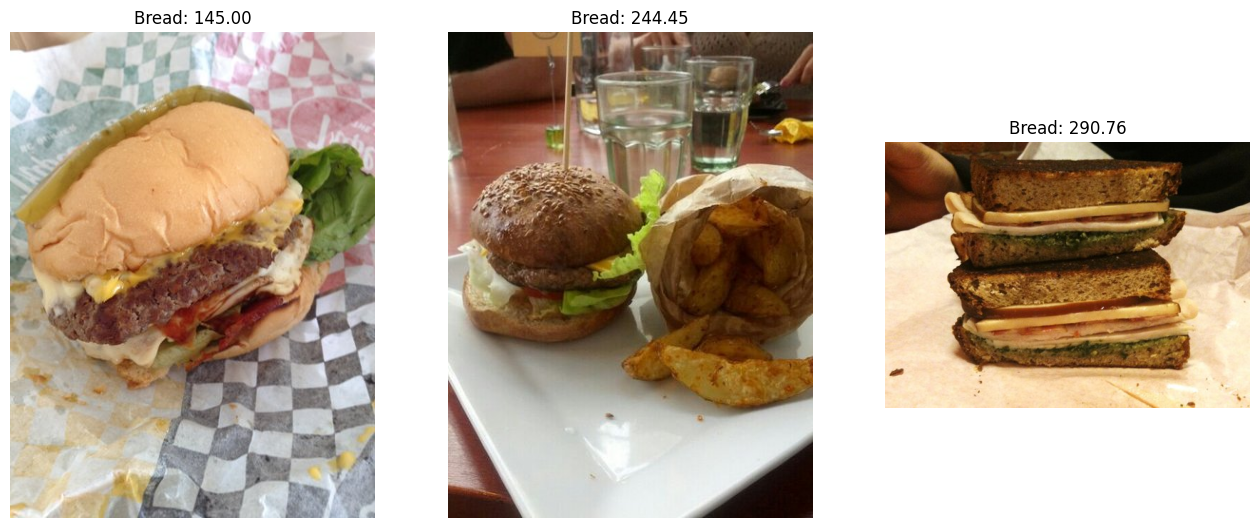

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 테스트를 위한 함수화

In [21]:
def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['53', '52', '36']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': 'Meat', 'uri': 'test/Meat/3.jpg'},
   {'uri': 'test/Meat/2.jpg', 'name': 'Meat'},
   {'name': 'Egg', 'uri': 'test/Egg/6.jpg'}]],
 'distances': [[250.5899658203125, 280.0551452636719, 282.2056579589844]]}

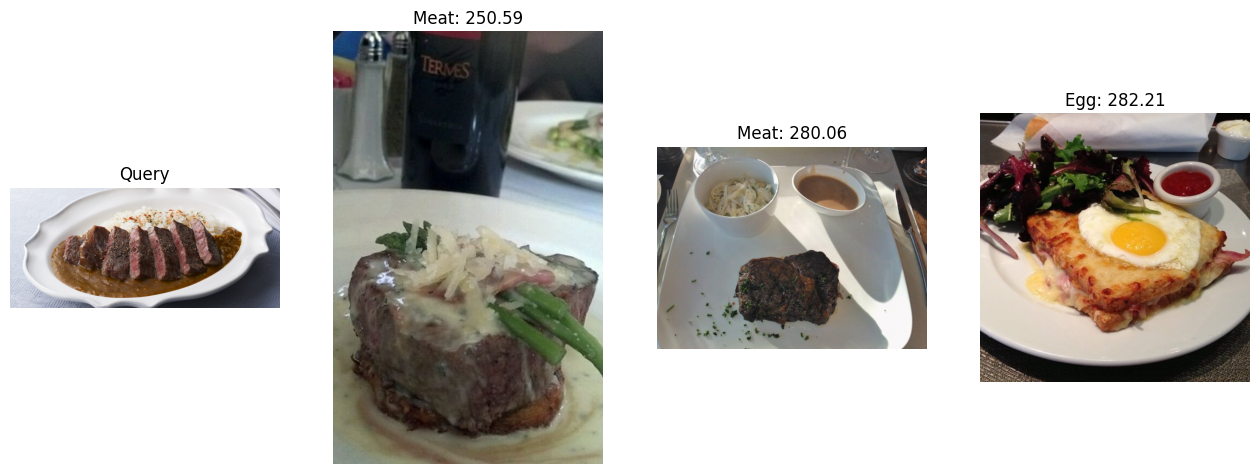

In [27]:
query("https://www.sbfoods-worldwide.com/ko/recipes/jvegc10000000kh9-img/Beefsteak_curry_recipe2.jpg")

{'ids': [['19', '47', '25']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': 'Dairy product', 'uri': 'test/Dairy product/9.jpg'},
   {'name': 'Fried food', 'uri': 'test/Fried food/7.jpg'},
   {'uri': 'test/Dessert/5.jpg', 'name': 'Dessert'}]],
 'distances': [[281.37359619140625, 283.69061279296875, 291.57550048828125]]}

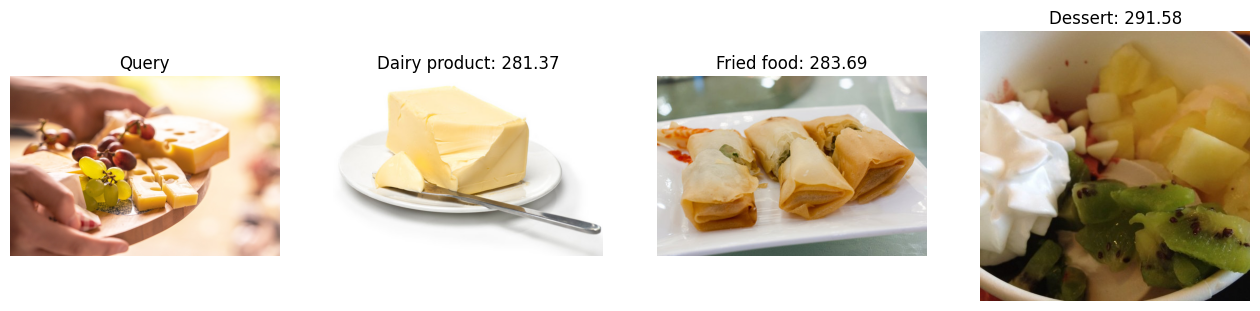

In [28]:
query("https://cdn.pixabay.com/photo/2021/04/05/14/48/cheese-platter-6153716_1280.jpg")

{'ids': [['77', '75', '72']],
 'distances': [[212.24978637695312, 226.03094482421875, 232.6399383544922]],
 'metadatas': [[{'name': 'Rice', 'uri': 'test/Rice/7.jpg'},
   {'name': 'Rice', 'uri': 'test/Rice/5.jpg'},
   {'name': 'Rice', 'uri': 'test/Rice/2.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

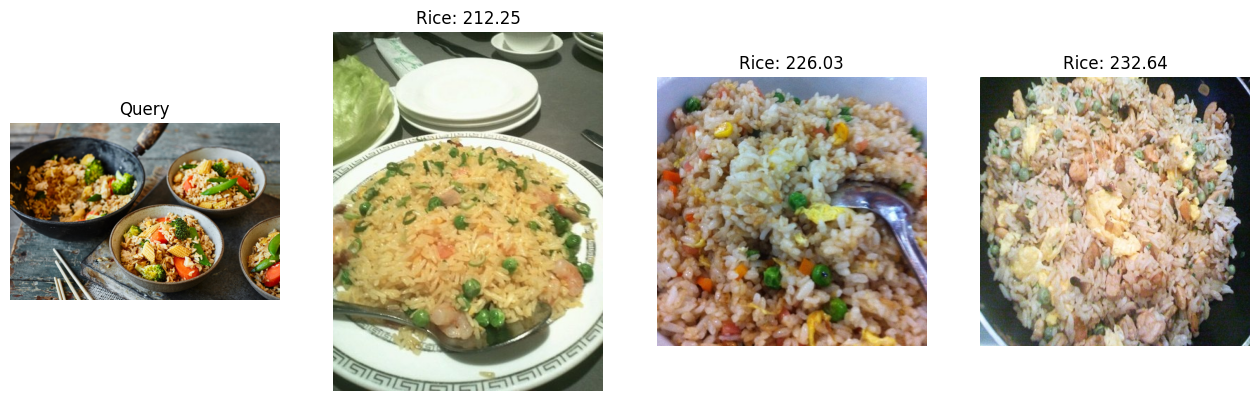

In [ ]:
query("https://i.imgur.com/WlLv0i9.png")